# Clustering Analysis (Birth Place Location)

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale
from lat_lon_parser import parse
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

## Import Excel Data

In [2]:
map = {}

# Loading Excel Data and adding each sheet into a map with its respective data
xls = pd.ExcelFile('nba_draft.xlsx')
for sheet_name in xls.sheet_names:
    map[sheet_name] = xls.parse(sheet_name)

## Initialize Parameters

In [3]:
# Define number of clusters (K)
num_clusters = 5

# Define the maximum draft pick number to be included in the analysis
max_draft_selection = 60

# Define the positions of interest
positions = []

# Define start year of draft class range
start_year = 1990

# Define end year of draft class range
end_year = 2020

# Define color theme for scatter plots
color_theme = np.array(['red','blue','green', 'yellow', 'orange', 'brown', 'purple', 'teal', 'dark blue', 'dark green'])

## Clean, Partition, Transform Data 

In [10]:
df = []

# Concatenate all sheets in draft class range 
for i in range(start_year, end_year):
    df.append(map['draft_data_{}'.format(i)])
location_df = pd.concat(df)   

# Filter draft picks
location_df = location_df[location_df['Pk']  <= max_draft_selection]

# Filter positions of interest
if len(positions) != 0:
    location_df = location_df[location_df['position'].isin(positions)]

# Get columns of interest 
loc_df = location_df.iloc[:, -2:]

# Drop null rows
loc_df = loc_df.dropna()

# Update longitude and latitude to decimal degree format
loc_df['bp_latitude'] = loc_df.bp_latitude.apply(lambda x: parse(x))  
loc_df['bp_longitude'] = loc_df.bp_longitude.apply(lambda x: parse(x)) 

# Create a copy of the above dataframe with the year column (for aggregation)
loc_df_with_years = location_df.iloc[:, list(range(50,52)) + [-3]]
loc_df_with_years = loc_df_with_years.dropna()

# Perform K-means clustering and define feature variables 
data = loc_df.to_numpy()
clustering  = KMeans(n_clusters=num_clusters,random_state=5)
clustering.fit(data)
loc_df.columns = ['Latitude','Longitude']

## Elbow Method

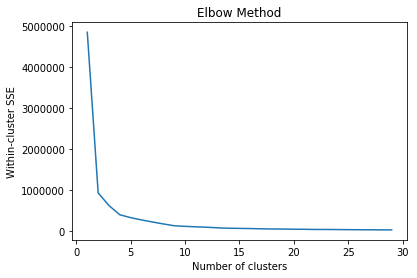

In [5]:
# Execute elbow method to determine optimal K value
distortations = {}
for k in range(1,30):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()),list(distortations.values()))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

## Clustering Output (2D Plots)

Clusters: [[  38.07968907 -111.69736004]
 [  41.34508357   21.23167531]
 [  38.25137709  -82.36114648]
 [  12.01107156  120.99307866]
 [   2.19905807  -49.48747594]]


-111.69736004421364, 38.079689068545996
21.2316753147336, 41.345083568965514
-82.36114648416867, 38.25137708849658
120.99307865806446, 12.011071564516126
-49.487475942857145, 2.199058066666666


red: Cluster 0
blue: Cluster 1
green: Cluster 2
yellow: Cluster 3
orange: Cluster 4


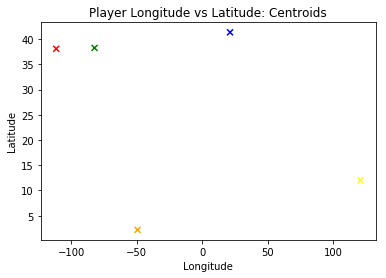

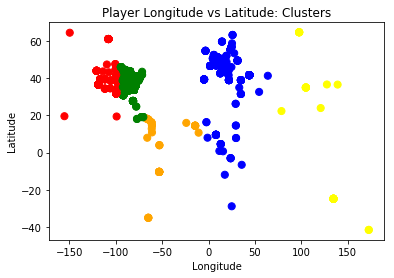

In [11]:
centroids = clustering.cluster_centers_
print('Clusters: {}'.format(centroids))
print('\n')
for i in range(len(centroids)):
    print('{}, {}'.format(centroids[i][1], centroids[i][0]))
print('\n')
t = np.arange(num_clusters)
for i in range(len(centroids)):
    print('{}: Cluster {}'.format(color_theme[i], i))

# Show centroid data in scatter plot
plt.scatter(centroids[:,1], centroids[:,0], marker="x", c=color_theme[t])
plt.title('Player Longitude vs Latitude: Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Show clustering results in scatter plot
plt.scatter(x=loc_df.Longitude,y=loc_df.Latitude,c=color_theme[clustering.labels_],s=50)
plt.title('Player Longitude vs Latitude: Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

##  Clustering Output Aggregations

In [7]:
# Aggregate clustering result, group by cluster and count rows
cluster_counts = {}
for i in range(len(clustering.labels_)):
    if clustering.labels_[i] not in cluster_counts:
        cluster_counts[clustering.labels_[i]] = 1
    else:
        cluster_counts[clustering.labels_[i]] += 1
print('Totals:')
for i in cluster_counts:
    print('{} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(cluster_counts[i], max_draft_selection, i))

print('Sum: {}'.format(sum(cluster_counts.values())))
print('\n')

# Further group cluster by decade 
decade_counts = {1990: {}, 2000: {}, 2010: {}}
for i in range(num_clusters):  
    decade_counts[1990.0][i] = 0
    decade_counts[2000.0][i] = 0
    decade_counts[2010.0][i] = 0

for i in range(len(clustering.labels_)):
    if (1990.0 <= loc_df_with_years.iloc[i][2] < 2000.0):  
        decade_counts[1990][clustering.labels_[i]] += 1
    elif (2000.0 <= loc_df_with_years.iloc[i][2] < 2010.0):  
        decade_counts[2000][clustering.labels_[i]] += 1
    elif (2010.0 <= loc_df_with_years.iloc[i][2] < 2020.0):  
        decade_counts[2010][clustering.labels_[i]] += 1
        
# Output aggregations calculated for each year by cluster
# Including percentage of each cluster count for given decade and total sum of prospects in each decade
for i in decade_counts:
    print('In the {}\'s'.format(i))
    for j in decade_counts[i]:
        percentage = str(decade_counts[i][j]/sum(decade_counts[i].values()))[:5]
        print('    ({}) {} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(percentage, decade_counts[i][j],max_draft_selection,  j))
    print('Sum: {}'.format(sum(decade_counts[i].values())))
    print('\n')

Totals:
878 players were drafted in the top 60 picks of their respective draft that fall in cluster 2
337 players were drafted in the top 60 picks of their respective draft that fall in cluster 0
319 players were drafted in the top 60 picks of their respective draft that fall in cluster 1
42 players were drafted in the top 60 picks of their respective draft that fall in cluster 4
31 players were drafted in the top 60 picks of their respective draft that fall in cluster 3
Sum: 1607


In the 1990's
    (0.204) 98 players were drafted in the top 60 picks of their respective draft that fall in cluster 0
    (0.108) 52 players were drafted in the top 60 picks of their respective draft that fall in cluster 1
    (0.665) 319 players were drafted in the top 60 picks of their respective draft that fall in cluster 2
    (0.010) 5 players were drafted in the top 60 picks of their respective draft that fall in cluster 3
    (0.010) 5 players were drafted in the top 60 picks of their respective dra

##  Cluster Dendogram

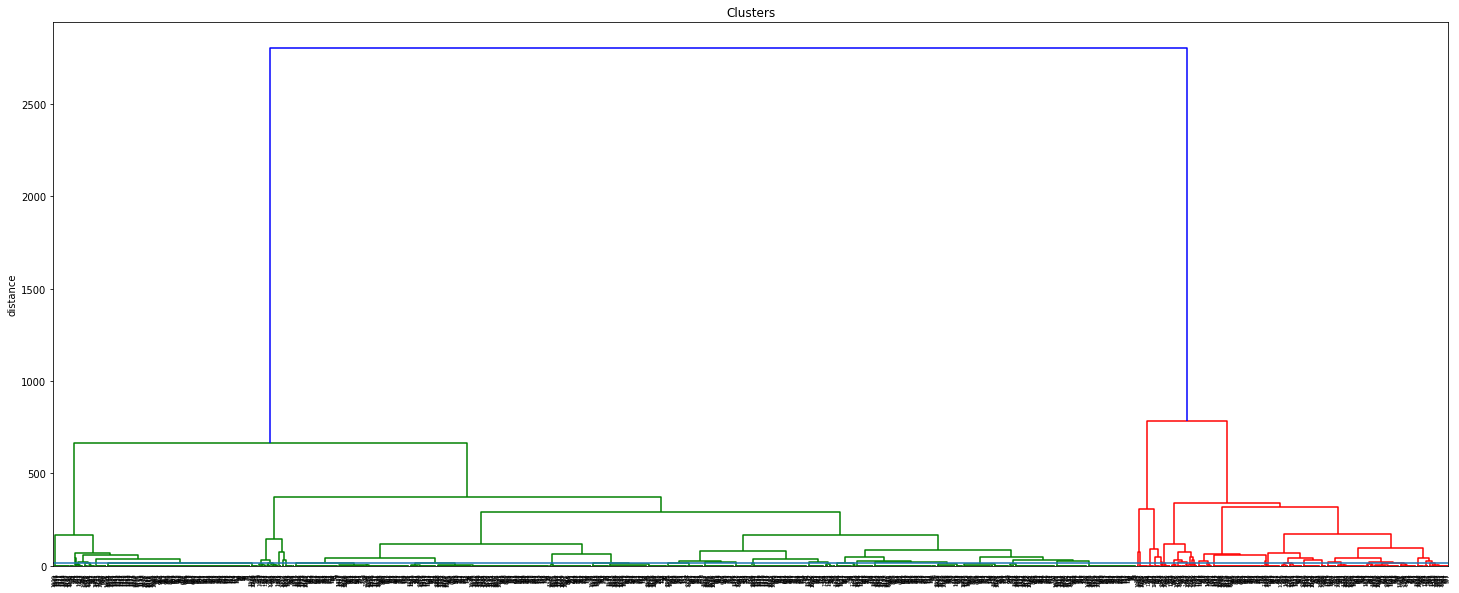

In [8]:
# Execute cluster dendogram
Z = linkage(data,'ward')

plt.figure(figsize=(25,10))
plt.title('Clusters')
plt.ylabel('distance')
dendrogram(Z)

plt.axhline(y=15)
plt.show()